In [1]:
import pandas as pd
import numpy as np
import re
import warnings
from datetime import datetime
from dateutil.parser import parse
from dateutil import tz
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import re

#pip install openpyxl 

## Limited Dictionary Classification Method

#### Read in transcript dataframes and filter for 2022

In [2]:
data_tucker=pd.read_csv('data/Carlson_cleaned.tsv',sep='\t').drop(columns = ['Unnamed: 0'])
data_maddow=pd.read_csv('data/Maddow_cleaned.tsv',sep='\t').drop(columns = ['Unnamed: 0'])


In [3]:

def filter_save(df, start_date, end_date):
    data_filt = df.loc[(df['timestamp'] > start_date) & (df['timestamp'] < end_date)] 

    return data_filt 

data_tucker =  filter_save(data_tucker, '2022-01-01', '2023-01-01').reset_index(drop=True)
data_maddow =  filter_save(data_maddow, '2022-01-01', '2023-01-01').reset_index(drop=True)

#### Read in and prepare PEW and transcript dataframes 
Create dictionary based on the limited dictionaries we came up with, seperating on commas so that 2-word combinations can be used with regex
Create columns for each PEW issue on both transcript dataframes, setting them as empty lists

In [4]:

#create dictionary based on the limited dictionaries column we added to the PEW polling data
def create_dict(file_name):
    pew= pd.read_excel(file_name)

    for count, pewrow in enumerate(pew['primary dict']):
        pew['primary dict'][count] = re.split(',',pewrow)
    
    return pew

pew = create_dict('data/Pew Issue Polling 2022.xlsx')

C:\Users\Owner\AppData\Local\Temp\ipykernel_12332\2483664682.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pew['primary dict'][count] = re.split(',',pewrow)


In [5]:
#add empty lists to all the issue columns so they can easily be extended
def lists(df, pew):
    for issue in pew['issue']: 
        df[issue] = np.empty((len(df), 0)).tolist()
    return df

data_tucker = lists(data_tucker, pew)
data_maddow =lists(data_maddow, pew)

#### Find matches between limited dictionaries and transcripts
Append each time a word or phrase from a limited dictionary is found within a transcript, the word is appended 
onto the empty list at its corresponding issue, transcript position in the dataframe

In [6]:

def find_matches(data, pew):
    categories = list(pew.issue)
    for cat_idx, category in enumerate(categories):
        for count, text in enumerate(data['stop words and lemmatization']):
            for word in pew['primary dict'][cat_idx]:
                match = re.findall(fr'\b{word}\b', text)
                data[category][count].extend(match) 
    return data

In [7]:
data2_tucker = find_matches(data_tucker, pew)
data2_maddow = find_matches(data_maddow, pew)

#### Assigning Documents to Topics
Assign transcripts to issue based on which issue's limited dictionary got the most mentions within in each transcript

In [8]:
copy_tucker=data2_tucker.iloc[:,6:].copy()
copy_maddow=data2_maddow.iloc[:,5:].copy()

In [9]:
def wordcount(x):
    if len(x) > 0:
        return len(x)
    else:
        return 0
    
def assign_transcipt(df):
    df=df.applymap(wordcount)
    
    m = np.zeros_like(df.values)
    m[np.arange(len(df)), df.values.argmax(1)] = 1

    newdf = pd.DataFrame(m, columns = df.columns).astype(int)
    
    return newdf
        

In [10]:
assigned_tucker = assign_transcipt(copy_tucker)
assigned_maddow = assign_transcipt(copy_maddow)


#### DataFrame Manipulation
Add host and timestamps back into each dataframe. Split apply combine is used with groupby to sum issue classifications by month,
then, both grouped dataframes are combined and converted into long format with pd.melt for visualization

In [11]:

def change_data (df):

    assigned_tucker['timestamp']  = pd.to_datetime(data_tucker['timestamp'])
    assigned_maddow['timestamp'] = pd.to_datetime(data_maddow['timestamp'])
    
    grouped_tucker= assigned_tucker.groupby(pd.Grouper(key='timestamp', axis=0, 
                          freq='M')).sum().reset_index()

    grouped_maddow= assigned_maddow.groupby(pd.Grouper(key='timestamp', axis=0, 
                          freq='M')).sum().reset_index() 
    
    grouped_tucker['host']='Tucker Carlson'
    grouped_maddow['host']='Rachel Maddow'
    
    final = pd.concat([grouped_tucker, grouped_maddow]).reset_index().sort_values(by='timestamp')
    
    final = final.rename(columns={
     'Issues around race and ethnicity':'Race and ethnicity',
     'Supreme Court appointments':'Supreme Court',
     'Size and scope of federal government': 'Size of gov',
     'Climate change': 'Climate change',
     'Voting policies': 'Voting policies',
     'The coronavirus outbreak': 'COVID outbreak',
     'Future of Democracy in the country': 'Future of Democracy',
     'Investigations into Trump':'Trump Investigations',
     'Investigations into Biden': 'Biden Investigations'})
    
    # use pd.melt to get the data into "long form" for they dynamic altair viz
    changedata = pd.melt(final, id_vars=['host','timestamp'], value_vars=['Abortion',
     'Education',
     'Immigration',
     'Violent crime',
     'Health care',
     'Gun policy',
     'Energy policy',
     'Economy',
     'Race and ethnicity',
     'Supreme Court',
     'Size of gov',
     'Climate change',
     'Voting policies',
     'Foreign policy',
     'COVID outbreak',
     'Future of Democracy',
     'Trump Investigations',
     'Biden Investigations',
     'host'])
    changedata['Issue']=changedata['variable']
    changedata['Month']=changedata['timestamp'].dt.month_name() #.str[:3]
    changedata['Transcripts per month as primary issue']=changedata['value']

    return changedata

changedata = change_data (assigned_tucker)
changedata = change_data (assigned_maddow)

#### Line Chart VIsualization in Altair

In [12]:
#Generate dynamic Altair chart

def generateLineChartP21(changedata):
    sort = ['January','February','March','April','May','June','July','August','September','October','November','December']

    #dropdown options for sorting data by indicator
    metricOptions = ['Tucker Carlson',
       'Rachel Maddow']
    
    input_dropdown = None
    
    dropdown_selection = None
    
    #input the dropdown menu and bind it to the dropdown selection that uses the indicators as its field
    input_dropdown = alt.binding_select(options=metricOptions, name="Host: ")
    dropdown_selection = alt.selection_single(fields=['host'], init={"host":metricOptions[0]}, bind=input_dropdown)
    

    #create a base line chart with a tooltip that will show the country name, year, and amount for every point on the graph
    line = alt.Chart(changedata).mark_line().encode( 
         x = alt.X('Month:N', title =None, sort=sort),
         y = 'Transcripts per month as primary issue:Q',
         tooltip=['Issue:N', 'Month:N'],
     
         color = alt.Color('Issue', 
                  )
    )
     
    #make a selection that will highlight individual lines based on the country name for the point that the mouse is nearest to   
    highlight = alt.selection(type='single', on='mouseover',
                          fields=['variable'], nearest=True)
    
    #mark the invisible points adding the highlight selection that determines which field to highlight based on mouseover proximity
    points1 = line.mark_circle().encode(
    opacity=alt.value(0)
    ).add_selection(
    highlight
    )
      
    #line chart that increases the size of the lines of the base line chart based on the condition of whether the mouse is closest
    #to a point on the highlight selection being used on the points
    lines = line.mark_line().encode(
    size=alt.condition(highlight, alt.value(4), alt.value(.8))
    )
    
    #layer the points and lines charts and add the dropdown selection that filters the data accordingly
    final = alt.layer(
        points1, lines).add_selection(
    dropdown_selection
    ).transform_filter(
    dropdown_selection
    )
    
    return final
generateLineChartP21(changedata)


alt.LayerChart(...)

#### Data Manipulation and Visualization for Bar Chart

Sum the values in the changedata dataframe on "host" and "variable" (issue) to enable a grouped bar plot visualization with Seaborn


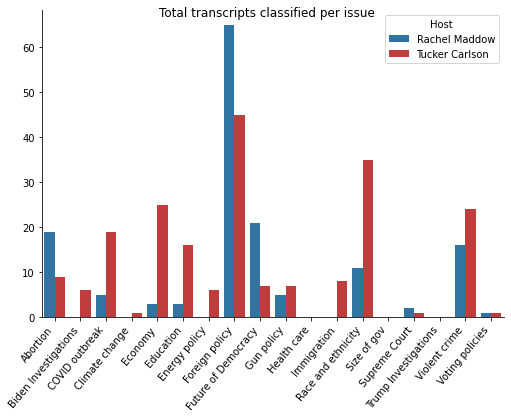

In [13]:

def make_barchart (df):
    sums= df.groupby(['host','variable']).sum().reset_index() #.drop(columns=['index'])
    
    palette = {
        'Rachel Maddow': 'tab:blue',
        'Tucker Carlson': 'tab:red',
    }

    g = sns.catplot(
        data=sums, kind="bar",
        x="variable", y="value", hue="host", legend = None,
        palette=palette, aspect=1.5)

    plt.xticks(rotation=(50), ha='right')
    plt.legend(loc='upper right', title='Host')
    #sns.move_legend(ax, "center right")
    #g.despine(left=True)
    g.set_axis_labels("","" )
    g.fig.suptitle("Total transcripts classified per issue")
    return 

make_barchart(changedata)